In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow as tf
import matplotlib.pyplot as plt

Вчитување на податоците

In [2]:
data = pd.read_csv('Desktop/data-formatted.csv')

Пред-процесирање на податоците

In [3]:
data['DATE'] = pd.to_datetime(data['DATE'])
grouped = data.groupby(['COMPANY', 'DATE'])['PRICE OF LAST TRANSACTION'].mean().reset_index()

In [4]:
grouped.sort_values(by=['COMPANY', 'DATE'], inplace=True)

Користиме grouped поради зачувување на оригиналните податоци

Ke ги искористиме предходните 3 дена за да направиме предикција, со помош на Lags

In [6]:
def add_lags(data, lags):
    lagged_data = pd.DataFrame()
    for company in data['COMPANY'].unique():
        company_data = data[data['COMPANY'] == company].copy()
        for lag in range(1, lags + 1):
            company_data[f'lag_{lag}'] = company_data['PRICE OF LAST TRANSACTION'].shift(lag)
        company_data.dropna(inplace=True)
        lagged_data = pd.concat([lagged_data, company_data])
    return lagged_data

In [7]:
data=add_lags(grouped, 3)

In [8]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
data['COMPANY_ENCODED'] = label_encoder.fit_transform(data['COMPANY'])
data.drop(columns=['COMPANY'], inplace=True)


Поделба на x , y и скалирање на податоците да имаме вредности помегу 0,1 за подобри резултати

In [9]:
x = data.drop(columns=['DATE', 'PRICE OF LAST TRANSACTION'])
y = data['PRICE OF LAST TRANSACTION']

In [10]:

scaler_X = MinMaxScaler(feature_range=(0, 1))
x = scaler_X.fit_transform(x)


scaler_y = MinMaxScaler(feature_range=(0, 1))
y = scaler_y.fit_transform(y.values.reshape(-1, 1))

In [11]:
from sklearn.model_selection import train_test_split

Поделба на податочното множество за валидација и тренирање

In [12]:
x_train, x_test, y_train, y_test=train_test_split(x, y, shuffle=False, test_size=0.3)

In [13]:
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

Градење на моделот

In [15]:
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)),
    Dropout(0.3),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(1)
])

C:\Users\HP\miniconda3\envs\lab1\Lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [16]:
model.compile(
    loss="mean_squared_error",
    optimizer="adam",
    metrics=["mean_squared_error"]
)

In [17]:
history = model.fit(x_train, y_train, epochs=20, batch_size=16)

Epoch 1/20
1328/1328 ━━━━━━━━━━━━━━━━━━━━ 32s 18ms/step - loss: 0.0068 - mean_squared_error: 0.0068
Epoch 2/20
1328/1328 ━━━━━━━━━━━━━━━━━━━━ 36s 14ms/step - loss: 0.0022 - mean_squared_error: 0.0022
Epoch 3/20
1328/1328 ━━━━━━━━━━━━━━━━━━━━ 24s 18ms/step - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 4/20
1328/1328 ━━━━━━━━━━━━━━━━━━━━ 35s 14ms/step - loss: 0.0023 - mean_squared_error: 0.0023
Epoch 5/20
1328/1328 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - loss: 0.0020 - mean_squared_error: 0.0020
Epoch 6/20
1328/1328 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - loss: 0.0022 - mean_squared_error: 0.0022
Epoch 7/20
1328/1328 ━━━━━━━━━━━━━━━━━━━━ 18s 12ms/step - loss: 0.0019 - mean_squared_error: 0.0019
Epoch 8/20
1328/1328 ━━━━━━━━━━━━━━━━━━━━ 22s 13ms/step - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 9/20
1328/1328 ━━━━━━━━━━━━━━━━━━━━ 23s 18ms/step - loss: 0.0025 - mean_squared_error: 0.0025
Epoch 10/20
1328/1328 ━━━━━━━━━━━━━━━━━━━━ 37s 14ms/step - loss: 0.0023 - mean_squared_error: 0.0023

In [18]:
y_pred=model.predict(x_test)

285/285 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step


In [19]:
y_pred=scaler_y.inverse_transform(y_pred)

In [20]:
y_test=scaler_y.inverse_transform(y_test)

In [21]:
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse}")

Root Mean Squared Error (RMSE): 5054.349663672311


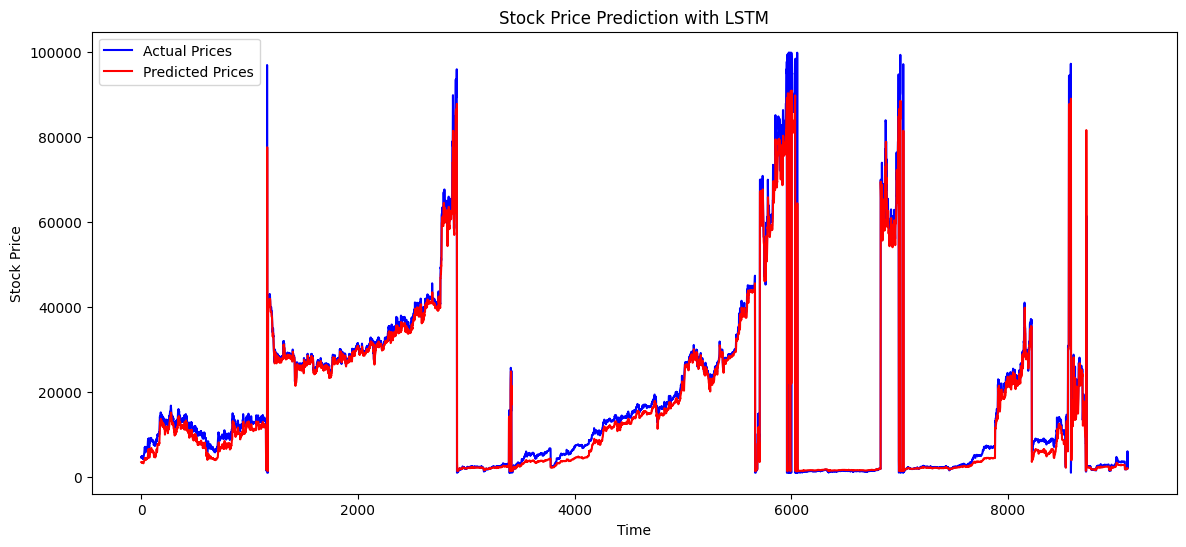

In [22]:
plt.figure(figsize=(14, 6))
plt.plot(y_test, label='Prices', color='blue')
plt.plot(y_pred, label='Predicted Prices', color='red')
plt.title('Предвидени Цени со LSTM Модел')
plt.xlabel('Време')
plt.ylabel('Stock Price')
plt.legend()
plt.show()
